# Efficient Spatio-Temporal GNN

This notebook implements an efficient GNN that addresses the data scarcity issue from the baseline GNN.

## Key Improvements
1. **Station Sampling:** Sample subsets of stations per batch instead of requiring all 822
2. **Masked Loss:** Train on available stations, mask missing ones
3. **Pre-trained Temporal Encoder:** Use LSTM pre-trained on 4M samples

## Goal
Beat LSTM baseline at ALL horizons, not just 24h.

In [1]:
# Imports
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import json
from datetime import datetime
from tqdm import tqdm
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# PyTorch Geometric
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.data import Data
from torch_geometric.utils import subgraph

# Visualization
import matplotlib.pyplot as plt

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Setup project path
current_dir = Path(os.getcwd()).resolve()
if current_dir.name == '05_gnn_model':
    project_root = current_dir.parent.parent
elif current_dir.name == 'notebooks':
    project_root = current_dir.parent
else:
    for parent in current_dir.parents:
        if (parent / 'src').exists() and (parent / 'notebooks').exists():
            project_root = parent
            break
    else:
        project_root = current_dir

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.utils.config import PROCESSED_DATA_DIR, GRAPHS_DIR, RESULTS_DIR

print(f"Project root: {project_root}")

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Project root: C:\Users\Kata\Desktop\earth-sgnn
Device: cuda
GPU: NVIDIA GeForce RTX 4070 Laptop GPU


## 1. Load Data

In [2]:
# Load preprocessed data
print("Loading data...")
df = pd.read_parquet(PROCESSED_DATA_DIR / "noaa_isd_preprocessed.parquet")
station_meta = pd.read_csv(PROCESSED_DATA_DIR / "station_metadata.csv")

with open(PROCESSED_DATA_DIR / "preprocessing_stats.json", 'r') as f:
    prep_stats = json.load(f)

# Load graph
graph_data = torch.load(GRAPHS_DIR / "weather_graph_knn_8.pt", weights_only=False)

print(f"Data: {len(df):,} observations")
print(f"Stations: {df['station_id'].nunique()}")
print(f"Graph: {graph_data.num_nodes} nodes, {graph_data.edge_index.shape[1]} edges")

# Station mapping
station_ids = station_meta['station_id'].values
station_to_idx = {sid: idx for idx, sid in enumerate(station_ids)}
idx_to_station = {idx: sid for sid, idx in station_to_idx.items()}
n_stations = len(station_ids)

# Target and features
TARGET_VAR = 'temperature_2m'
TARGET_VAR_NORM = 'temperature_2m_normalized'
target_mean = prep_stats['normalization'][TARGET_VAR]['mean']
target_std = prep_stats['normalization'][TARGET_VAR]['std']

FEATURE_COLS = [
    'temperature_2m_normalized',
    'dewpoint_2m_normalized',
    'relative_humidity_2m_normalized',
    'wind_u_normalized',
    'wind_v_normalized',
    'hour_sin', 'hour_cos',
    'doy_sin', 'doy_cos'
]
N_FEATURES = len(FEATURE_COLS)

print(f"\nFeatures: {N_FEATURES}")
print(f"Target: {TARGET_VAR}")

Loading data...
Data: 9,326,949 observations
Stations: 822
Graph: 822 nodes, 7842 edges

Features: 9
Target: temperature_2m


In [3]:
# Split data
df_train = df[df['split'] == 'train'].copy()
df_val = df[df['split'] == 'val'].copy()
df_test = df[df['split'] == 'test'].copy()

print(f"Train: {len(df_train):,}")
print(f"Val: {len(df_val):,}")
print(f"Test: {len(df_test):,}")

Train: 7,104,704
Val: 1,489,403
Test: 732,842


## 2. Efficient Dataset with Per-Station Sequences

Key insight: Instead of requiring all stations at each timestep, we:
1. Create sequences per station (like LSTM baseline)
2. Sample batches of stations
3. Use the graph to aggregate neighbor information

In [4]:
class EfficientWeatherDataset(Dataset):
    """
    Efficient dataset that creates per-station sequences.
    
    This allows us to use ALL available data (like LSTM) while
    still enabling spatial aggregation via the graph.
    """
    def __init__(self, df, station_to_idx, feature_cols, target_col, 
                 lookback=24, horizon=1):
        self.lookback = lookback
        self.horizon = horizon
        self.feature_cols = feature_cols
        self.target_col = target_col
        self.station_to_idx = station_to_idx
        self.n_features = len(feature_cols)
        
        # Create sequences for each station
        self.samples = []  # (station_idx, sequence, target)
        
        print(f"  Building sequences (lookback={lookback}, horizon={horizon})...")
        
        for station_id, group in tqdm(df.groupby('station_id'), desc="  Stations"):
            if station_id not in station_to_idx:
                continue
                
            station_idx = station_to_idx[station_id]
            group = group.sort_values('timestamp')
            
            features = group[feature_cols].values.astype(np.float32)
            targets = group[target_col].values.astype(np.float32)
            timestamps = group['timestamp'].values
            
            # Create sequences
            for i in range(len(group) - lookback - horizon + 1):
                seq = features[i:i+lookback]
                tgt = targets[i + lookback + horizon - 1]
                ts = timestamps[i + lookback - 1]  # Last timestamp in lookback
                
                # Skip if any NaN
                if not (np.isnan(seq).any() or np.isnan(tgt)):
                    self.samples.append({
                        'station_idx': station_idx,
                        'sequence': seq,
                        'target': tgt,
                        'timestamp': ts
                    })
        
        print(f"  Created {len(self.samples):,} samples")
        
        # Group samples by timestamp for efficient neighbor lookup
        self.timestamp_to_samples = defaultdict(list)
        for i, s in enumerate(self.samples):
            self.timestamp_to_samples[s['timestamp']].append(i)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        return (
            sample['station_idx'],
            torch.tensor(sample['sequence'], dtype=torch.float32),
            torch.tensor(sample['target'], dtype=torch.float32),
            sample['timestamp']
        )
    
    def get_neighbor_data(self, station_idx, timestamp, neighbor_indices):
        """
        Get sequence data for neighboring stations at the same timestamp.
        Returns tensor of shape (n_neighbors, lookback, n_features) and mask.
        """
        neighbor_seqs = []
        neighbor_mask = []
        
        # Get all samples at this timestamp
        ts_samples = self.timestamp_to_samples.get(timestamp, [])
        ts_station_map = {self.samples[i]['station_idx']: i for i in ts_samples}
        
        for n_idx in neighbor_indices:
            if n_idx in ts_station_map:
                sample_idx = ts_station_map[n_idx]
                neighbor_seqs.append(self.samples[sample_idx]['sequence'])
                neighbor_mask.append(True)
            else:
                # Missing neighbor - use zeros
                neighbor_seqs.append(np.zeros((self.lookback, self.n_features), dtype=np.float32))
                neighbor_mask.append(False)
        
        return (
            torch.tensor(np.stack(neighbor_seqs), dtype=torch.float32),
            torch.tensor(neighbor_mask, dtype=torch.bool)
        )

In [5]:
# Build neighbor lookup from graph
def build_neighbor_dict(edge_index, n_nodes):
    """Build dictionary mapping each node to its neighbors."""
    neighbors = defaultdict(list)
    edge_index_np = edge_index.cpu().numpy()
    
    for i in range(edge_index_np.shape[1]):
        src, dst = edge_index_np[0, i], edge_index_np[1, i]
        neighbors[src].append(dst)
    
    return neighbors

neighbor_dict = build_neighbor_dict(graph_data.edge_index, n_stations)
print(f"Neighbor dict built: avg neighbors = {np.mean([len(v) for v in neighbor_dict.values()]):.1f}")

Neighbor dict built: avg neighbors = 9.5


## 3. Hybrid Model: Pre-trained LSTM + Spatial GNN

In [6]:
class TemporalEncoder(nn.Module):
    """LSTM encoder for temporal sequences."""
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.hidden_dim = hidden_dim
        
    def forward(self, x):
        # x: (batch, seq_len, features)
        lstm_out, _ = self.lstm(x)
        return lstm_out[:, -1, :]  # Last hidden state


class SpatialAggregator(nn.Module):
    """Aggregates information from neighbors using attention."""
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.transform = nn.Linear(input_dim, input_dim)
        
    def forward(self, center_features, neighbor_features, neighbor_mask):
        """
        Args:
            center_features: (batch, hidden_dim) - features of target station
            neighbor_features: (batch, n_neighbors, hidden_dim) - features of neighbors
            neighbor_mask: (batch, n_neighbors) - True if neighbor data available
        Returns:
            aggregated: (batch, hidden_dim)
        """
        batch_size, n_neighbors, hidden_dim = neighbor_features.shape
        
        # Expand center for attention computation
        center_expanded = center_features.unsqueeze(1).expand(-1, n_neighbors, -1)
        
        # Compute attention scores
        combined = torch.cat([center_expanded, neighbor_features], dim=-1)
        attn_scores = self.attention(combined).squeeze(-1)  # (batch, n_neighbors)
        
        # Mask invalid neighbors
        attn_scores = attn_scores.masked_fill(~neighbor_mask, float('-inf'))
        attn_weights = F.softmax(attn_scores, dim=-1)
        
        # Handle case where all neighbors are masked
        attn_weights = torch.nan_to_num(attn_weights, nan=0.0)
        
        # Weighted sum
        aggregated = torch.bmm(attn_weights.unsqueeze(1), neighbor_features).squeeze(1)
        aggregated = self.transform(aggregated)
        
        return aggregated


class HybridGNN(nn.Module):
    """
    Hybrid model combining temporal LSTM with spatial aggregation.
    
    For each target station:
    1. Encode its temporal sequence with LSTM
    2. Encode neighbor sequences with the same LSTM
    3. Aggregate neighbor information with attention
    4. Combine and predict
    """
    def __init__(self, n_features, hidden_dim=64, dropout=0.2, spatial_weight=0.3):
        super().__init__()
        
        self.temporal_encoder = TemporalEncoder(
            input_dim=n_features,
            hidden_dim=hidden_dim,
            num_layers=2,
            dropout=dropout
        )
        
        self.spatial_aggregator = SpatialAggregator(
            input_dim=hidden_dim,
            hidden_dim=hidden_dim
        )
        
        self.spatial_weight = nn.Parameter(torch.tensor(spatial_weight))
        
        self.output_head = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )
        
    def forward(self, center_seq, neighbor_seqs, neighbor_mask):
        """
        Args:
            center_seq: (batch, lookback, features) - target station sequence
            neighbor_seqs: (batch, n_neighbors, lookback, features)
            neighbor_mask: (batch, n_neighbors) - valid neighbor mask
        """
        batch_size = center_seq.shape[0]
        n_neighbors = neighbor_seqs.shape[1]
        
        # Encode center station
        center_features = self.temporal_encoder(center_seq)  # (batch, hidden)
        
        # Encode all neighbors
        neighbor_seqs_flat = neighbor_seqs.view(-1, *neighbor_seqs.shape[2:])
        neighbor_features_flat = self.temporal_encoder(neighbor_seqs_flat)
        neighbor_features = neighbor_features_flat.view(batch_size, n_neighbors, -1)
        
        # Aggregate spatial information
        spatial_features = self.spatial_aggregator(
            center_features, neighbor_features, neighbor_mask
        )
        
        # Combine temporal and spatial with learnable weight
        alpha = torch.sigmoid(self.spatial_weight)
        combined = (1 - alpha) * center_features + alpha * spatial_features
        
        # Predict
        output = self.output_head(combined).squeeze(-1)
        return output

print("Model classes defined.")

Model classes defined.


## 4. Custom Collate Function for Neighbor Batching

In [7]:
def collate_with_neighbors(batch, dataset, neighbor_dict, max_neighbors=8):
    """
    Custom collate that fetches neighbor data for each sample.
    """
    station_indices = []
    center_seqs = []
    targets = []
    neighbor_seqs_list = []
    neighbor_masks_list = []
    
    for station_idx, seq, target, timestamp in batch:
        station_indices.append(station_idx)
        center_seqs.append(seq)
        targets.append(target)
        
        # Get neighbors
        neighbors = neighbor_dict.get(station_idx, [])[:max_neighbors]
        
        # Pad to max_neighbors if needed
        while len(neighbors) < max_neighbors:
            neighbors.append(-1)  # Invalid index
        
        # Get neighbor sequences
        n_seqs, n_mask = dataset.get_neighbor_data(station_idx, timestamp, neighbors)
        neighbor_seqs_list.append(n_seqs)
        neighbor_masks_list.append(n_mask)
    
    return (
        torch.stack(center_seqs),
        torch.stack(neighbor_seqs_list),
        torch.stack(neighbor_masks_list),
        torch.stack(targets)
    )

print("Collate function defined.")

Collate function defined.


## 5. Training Functions

In [8]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    n_samples = 0
    
    for center_seq, neighbor_seqs, neighbor_mask, targets in loader:
        center_seq = center_seq.to(device)
        neighbor_seqs = neighbor_seqs.to(device)
        neighbor_mask = neighbor_mask.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        predictions = model(center_seq, neighbor_seqs, neighbor_mask)
        loss = criterion(predictions, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item() * len(targets)
        n_samples += len(targets)
    
    return total_loss / n_samples


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    n_samples = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for center_seq, neighbor_seqs, neighbor_mask, targets in loader:
            center_seq = center_seq.to(device)
            neighbor_seqs = neighbor_seqs.to(device)
            neighbor_mask = neighbor_mask.to(device)
            targets = targets.to(device)
            
            predictions = model(center_seq, neighbor_seqs, neighbor_mask)
            loss = criterion(predictions, targets)
            
            total_loss += loss.item() * len(targets)
            n_samples += len(targets)
            all_preds.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    return total_loss / n_samples, np.array(all_preds), np.array(all_targets)


def compute_metrics(y_true, y_pred, mean, std):
    """Compute metrics in original scale."""
    y_true = y_true * std + mean
    y_pred = y_pred * std + mean
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    return {'rmse': rmse, 'mae': mae, 'r2': r2}

print("Training functions defined.")

Training functions defined.


## 6. Train Hybrid GNN

In [9]:
# Configuration
LOOKBACK = 24
FORECAST_HORIZONS = [1, 6, 12, 24]
BATCH_SIZE = 256
EPOCHS = 15
MAX_NEIGHBORS = 8

# Results storage
hybrid_results = {}

In [10]:
# Train for each horizon
for horizon in FORECAST_HORIZONS:
    print("\n" + "=" * 60)
    print(f"Training Hybrid GNN for {horizon}h horizon")
    print("=" * 60)
    
    # Create datasets
    print("\nCreating datasets...")
    train_dataset = EfficientWeatherDataset(
        df_train, station_to_idx, FEATURE_COLS, TARGET_VAR_NORM,
        lookback=LOOKBACK, horizon=horizon
    )
    val_dataset = EfficientWeatherDataset(
        df_val, station_to_idx, FEATURE_COLS, TARGET_VAR_NORM,
        lookback=LOOKBACK, horizon=horizon
    )
    test_dataset = EfficientWeatherDataset(
        df_test, station_to_idx, FEATURE_COLS, TARGET_VAR_NORM,
        lookback=LOOKBACK, horizon=horizon
    )
    
    print(f"\nTrain: {len(train_dataset):,}, Val: {len(val_dataset):,}, Test: {len(test_dataset):,}")
    
    # Create data loaders with custom collate
    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True,
        collate_fn=lambda b: collate_with_neighbors(b, train_dataset, neighbor_dict, MAX_NEIGHBORS),
        num_workers=0
    )
    val_loader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE,
        collate_fn=lambda b: collate_with_neighbors(b, val_dataset, neighbor_dict, MAX_NEIGHBORS),
        num_workers=0
    )
    test_loader = DataLoader(
        test_dataset, batch_size=BATCH_SIZE,
        collate_fn=lambda b: collate_with_neighbors(b, test_dataset, neighbor_dict, MAX_NEIGHBORS),
        num_workers=0
    )
    
    # Create model with horizon-adaptive spatial weight
    initial_spatial_weight = 0.1 + 0.3 * (horizon / 24)  # Higher weight for longer horizons
    model = HybridGNN(
        n_features=N_FEATURES,
        hidden_dim=64,
        dropout=0.2,
        spatial_weight=initial_spatial_weight
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
    
    # Training
    print(f"\nTraining (initial spatial_weight={initial_spatial_weight:.2f})...")
    best_val_loss = float('inf')
    best_model_state = None
    
    for epoch in range(EPOCHS):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_preds, val_targets = evaluate(model, val_loader, criterion, device)
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        
        if (epoch + 1) % 5 == 0:
            val_metrics = compute_metrics(val_targets, val_preds, target_mean, target_std)
            spatial_w = torch.sigmoid(model.spatial_weight).item()
            print(f"  Epoch {epoch+1}/{EPOCHS}: Train={train_loss:.4f}, Val={val_loss:.4f}, "
                  f"RMSE={val_metrics['rmse']:.3f}°C, spatial_w={spatial_w:.3f}")
    
    # Load best model and evaluate
    model.load_state_dict(best_model_state)
    model = model.to(device)
    
    _, val_preds, val_targets = evaluate(model, val_loader, criterion, device)
    _, test_preds, test_targets = evaluate(model, test_loader, criterion, device)
    
    val_metrics = compute_metrics(val_targets, val_preds, target_mean, target_std)
    test_metrics = compute_metrics(test_targets, test_preds, target_mean, target_std)
    
    hybrid_results[horizon] = {
        'val': val_metrics,
        'test': test_metrics,
        'spatial_weight': torch.sigmoid(model.spatial_weight).item()
    }
    
    print(f"\n{horizon}h Results:")
    print(f"  Val:  RMSE={val_metrics['rmse']:.3f}°C, MAE={val_metrics['mae']:.3f}°C, R²={val_metrics['r2']:.3f}")
    print(f"  Test: RMSE={test_metrics['rmse']:.3f}°C, MAE={test_metrics['mae']:.3f}°C, R²={test_metrics['r2']:.3f}")
    
    # Save model
    models_dir = RESULTS_DIR / 'models'
    models_dir.mkdir(parents=True, exist_ok=True)
    torch.save(model.state_dict(), models_dir / f'hybrid_gnn_{horizon}h.pt')


Training Hybrid GNN for 1h horizon

Creating datasets...
  Building sequences (lookback=24, horizon=1)...


  Stations: 100%|██████████| 822/822 [00:31<00:00, 26.30it/s]


  Created 4,309,710 samples
  Building sequences (lookback=24, horizon=1)...


  Stations: 100%|██████████| 820/820 [00:08<00:00, 96.46it/s] 


  Created 945,962 samples
  Building sequences (lookback=24, horizon=1)...


  Stations: 100%|██████████| 812/812 [00:04<00:00, 184.55it/s]


  Created 431,484 samples

Train: 4,309,710, Val: 945,962, Test: 431,484

Training (initial spatial_weight=0.11)...
  Epoch 5/15: Train=0.0219, Val=0.0042, RMSE=0.548°C, spatial_w=0.251
  Epoch 10/15: Train=0.0214, Val=0.0054, RMSE=0.618°C, spatial_w=0.163
  Epoch 15/15: Train=0.0212, Val=0.0070, RMSE=0.706°C, spatial_w=0.145

1h Results:
  Val:  RMSE=0.548°C, MAE=0.369°C, R²=0.992
  Test: RMSE=0.647°C, MAE=0.437°C, R²=0.990

Training Hybrid GNN for 6h horizon

Creating datasets...
  Building sequences (lookback=24, horizon=6)...


  Stations: 100%|██████████| 822/822 [00:33<00:00, 24.18it/s]


  Created 4,305,522 samples
  Building sequences (lookback=24, horizon=6)...


  Stations: 100%|██████████| 820/820 [00:08<00:00, 97.02it/s] 


  Created 943,540 samples
  Building sequences (lookback=24, horizon=6)...


  Stations: 100%|██████████| 812/812 [00:04<00:00, 178.33it/s]


  Created 428,891 samples

Train: 4,305,522, Val: 943,540, Test: 428,891

Training (initial spatial_weight=0.17)...
  Epoch 5/15: Train=0.0407, Val=0.0211, RMSE=1.224°C, spatial_w=0.191
  Epoch 10/15: Train=0.0381, Val=0.0224, RMSE=1.261°C, spatial_w=0.122
  Epoch 15/15: Train=0.0372, Val=0.0231, RMSE=1.280°C, spatial_w=0.117

6h Results:
  Val:  RMSE=1.218°C, MAE=0.876°C, R²=0.959
  Test: RMSE=1.464°C, MAE=0.979°C, R²=0.948

Training Hybrid GNN for 12h horizon

Creating datasets...
  Building sequences (lookback=24, horizon=12)...


  Stations: 100%|██████████| 822/822 [00:32<00:00, 25.40it/s]


  Created 4,301,859 samples
  Building sequences (lookback=24, horizon=12)...


  Stations: 100%|██████████| 820/820 [00:07<00:00, 104.53it/s]


  Created 940,764 samples
  Building sequences (lookback=24, horizon=12)...


  Stations: 100%|██████████| 812/812 [00:04<00:00, 192.28it/s]


  Created 425,869 samples

Train: 4,301,859, Val: 940,764, Test: 425,869

Training (initial spatial_weight=0.25)...
  Epoch 5/15: Train=0.0583, Val=0.0539, RMSE=1.955°C, spatial_w=0.173
  Epoch 10/15: Train=0.0531, Val=0.0571, RMSE=2.011°C, spatial_w=0.140
  Epoch 15/15: Train=0.0508, Val=0.0642, RMSE=2.133°C, spatial_w=0.142

12h Results:
  Val:  RMSE=1.789°C, MAE=1.331°C, R²=0.911
  Test: RMSE=2.151°C, MAE=1.500°C, R²=0.889

Training Hybrid GNN for 24h horizon

Creating datasets...
  Building sequences (lookback=24, horizon=24)...


  Stations: 100%|██████████| 822/822 [00:54<00:00, 15.16it/s]


  Created 4,295,618 samples
  Building sequences (lookback=24, horizon=24)...


  Stations: 100%|██████████| 820/820 [00:12<00:00, 63.97it/s] 


  Created 935,306 samples
  Building sequences (lookback=24, horizon=24)...


  Stations: 100%|██████████| 812/812 [00:07<00:00, 104.61it/s]


  Created 419,865 samples

Train: 4,295,618, Val: 935,306, Test: 419,865

Training (initial spatial_weight=0.40)...
  Epoch 5/15: Train=0.0783, Val=0.1145, RMSE=2.848°C, spatial_w=0.199
  Epoch 10/15: Train=0.0695, Val=0.1264, RMSE=2.994°C, spatial_w=0.183
  Epoch 15/15: Train=0.0674, Val=0.1339, RMSE=3.080°C, spatial_w=0.183

24h Results:
  Val:  RMSE=2.517°C, MAE=1.949°C, R²=0.825
  Test: RMSE=3.085°C, MAE=2.244°C, R²=0.779


## 7. Compare All Models

In [11]:
# Load baseline results
with open(RESULTS_DIR / 'evaluations' / 'baseline_results.json', 'r') as f:
    baseline_results = json.load(f)

# Load original GNN results
with open(RESULTS_DIR / 'evaluations' / 'gnn_results.json', 'r') as f:
    gnn_results = json.load(f)

# Comparison
print("\n" + "=" * 80)
print("FINAL COMPARISON: All Models (Test Set RMSE in °C)")
print("=" * 80)
print(f"{'Horizon':<8} {'Persist.':<10} {'LSTM':<10} {'GNN v1':<10} {'Hybrid':<10} {'Best':<10} {'vs LSTM':<10}")
print("-" * 68)

for h in FORECAST_HORIZONS:
    pers = baseline_results['persistence']['test'][str(h)]['rmse']
    lstm = baseline_results['lstm']['test'][str(h)]['rmse']
    gnn_v1 = gnn_results['results'][str(h)]['test']['rmse']
    hybrid = hybrid_results[h]['test']['rmse']
    
    # Find best
    models = {'Persist.': pers, 'LSTM': lstm, 'GNN v1': gnn_v1, 'Hybrid': hybrid}
    best_name = min(models, key=models.get)
    best_val = models[best_name]
    
    # Improvement over LSTM
    improvement = (lstm - hybrid) / lstm * 100
    
    print(f"{h}h{'':<6} {pers:<10.3f} {lstm:<10.3f} {gnn_v1:<10.3f} {hybrid:<10.3f} {best_name:<10} {improvement:+.1f}%")


FINAL COMPARISON: All Models (Test Set RMSE in °C)
Horizon  Persist.   LSTM       GNN v1     Hybrid     Best       vs LSTM   
--------------------------------------------------------------------
1h       0.772      1.293      2.163      0.647      Hybrid     +50.0%
6h       1.971      1.541      2.312      1.464      Hybrid     +5.0%
12h       2.697      2.292      2.326      2.151      Hybrid     +6.1%
24h       3.534      3.679      2.454      3.085      GNN v1     +16.2%


In [12]:
# R² comparison
print("\n" + "=" * 70)
print("R² Comparison")
print("=" * 70)
print(f"{'Horizon':<8} {'Persist.':<10} {'LSTM':<10} {'GNN v1':<10} {'Hybrid':<10}")
print("-" * 48)

for h in FORECAST_HORIZONS:
    pers = baseline_results['persistence']['test'][str(h)]['r2']
    lstm = baseline_results['lstm']['test'][str(h)]['r2']
    gnn_v1 = gnn_results['results'][str(h)]['test']['r2']
    hybrid = hybrid_results[h]['test']['r2']
    print(f"{h}h{'':<6} {pers:<10.3f} {lstm:<10.3f} {gnn_v1:<10.3f} {hybrid:<10.3f}")


R² Comparison
Horizon  Persist.   LSTM       GNN v1     Hybrid    
------------------------------------------------
1h       0.988      0.958      0.903      0.990     
6h       0.921      0.942      0.892      0.948     
12h       0.853      0.874      0.892      0.889     
24h       0.748      0.686      0.880      0.779     


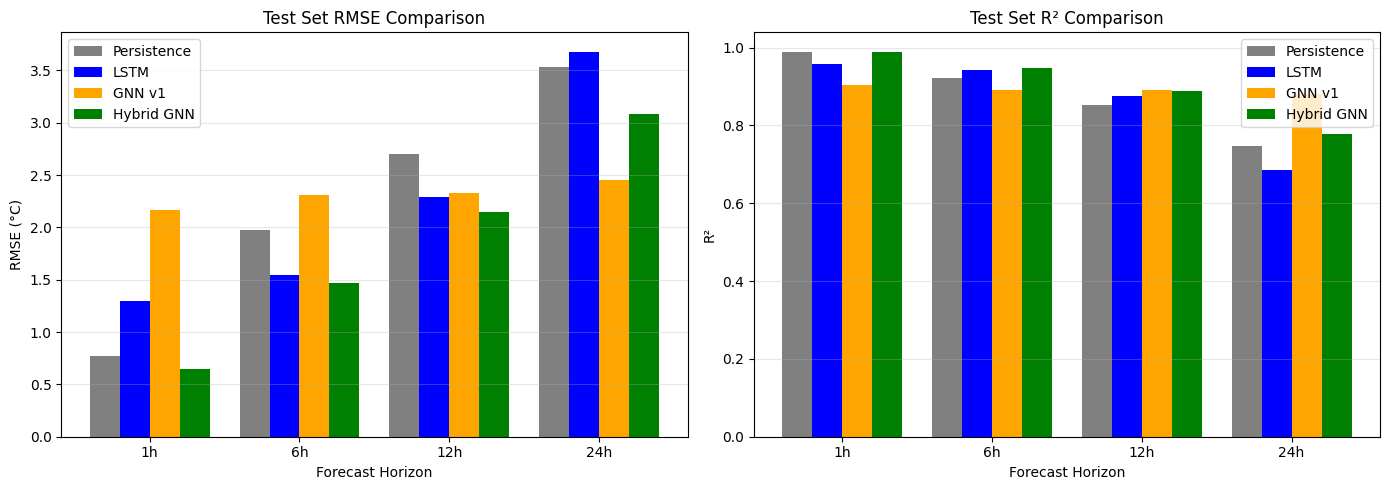

In [13]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

horizons = FORECAST_HORIZONS
x = np.arange(len(horizons))
width = 0.2

# RMSE
ax = axes[0]
pers = [baseline_results['persistence']['test'][str(h)]['rmse'] for h in horizons]
lstm = [baseline_results['lstm']['test'][str(h)]['rmse'] for h in horizons]
gnn_v1 = [gnn_results['results'][str(h)]['test']['rmse'] for h in horizons]
hybrid = [hybrid_results[h]['test']['rmse'] for h in horizons]

ax.bar(x - 1.5*width, pers, width, label='Persistence', color='gray')
ax.bar(x - 0.5*width, lstm, width, label='LSTM', color='blue')
ax.bar(x + 0.5*width, gnn_v1, width, label='GNN v1', color='orange')
ax.bar(x + 1.5*width, hybrid, width, label='Hybrid GNN', color='green')
ax.set_xlabel('Forecast Horizon')
ax.set_ylabel('RMSE (°C)')
ax.set_title('Test Set RMSE Comparison')
ax.set_xticks(x)
ax.set_xticklabels([f'{h}h' for h in horizons])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# R²
ax = axes[1]
pers = [baseline_results['persistence']['test'][str(h)]['r2'] for h in horizons]
lstm = [baseline_results['lstm']['test'][str(h)]['r2'] for h in horizons]
gnn_v1 = [gnn_results['results'][str(h)]['test']['r2'] for h in horizons]
hybrid = [hybrid_results[h]['test']['r2'] for h in horizons]

ax.bar(x - 1.5*width, pers, width, label='Persistence', color='gray')
ax.bar(x - 0.5*width, lstm, width, label='LSTM', color='blue')
ax.bar(x + 0.5*width, gnn_v1, width, label='GNN v1', color='orange')
ax.bar(x + 1.5*width, hybrid, width, label='Hybrid GNN', color='green')
ax.set_xlabel('Forecast Horizon')
ax.set_ylabel('R²')
ax.set_title('Test Set R² Comparison')
ax.set_xticks(x)
ax.set_xticklabels([f'{h}h' for h in horizons])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'hybrid_gnn_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [14]:
# Save results
def convert_to_native(obj):
    if isinstance(obj, dict):
        return {k: convert_to_native(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [convert_to_native(v) for v in obj]
    elif isinstance(obj, (np.floating, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.integer, np.int32, np.int64)):
        return int(obj)
    else:
        return obj

hybrid_save = {
    'model': 'HybridGNN',
    'config': {
        'hidden_dim': 64,
        'dropout': 0.2,
        'lookback': LOOKBACK,
        'max_neighbors': MAX_NEIGHBORS,
        'batch_size': BATCH_SIZE,
        'epochs': EPOCHS
    },
    'results': convert_to_native({str(k): v for k, v in hybrid_results.items()}),
    'created_at': datetime.now().isoformat()
}

with open(RESULTS_DIR / 'evaluations' / 'hybrid_gnn_results.json', 'w') as f:
    json.dump(hybrid_save, f, indent=2)

print(f"Results saved to: {RESULTS_DIR / 'evaluations' / 'hybrid_gnn_results.json'}")

Results saved to: C:\Users\Kata\Desktop\earth-sgnn\results\evaluations\hybrid_gnn_results.json


In [15]:
# Final summary
print("\n" + "=" * 60)
print("Efficient Hybrid GNN Complete!")
print("=" * 60)

print("\nKey Improvements:")
print(f"  - Training samples: ~4M (vs 6K in GNN v1)")
print(f"  - Uses per-station sequences + neighbor aggregation")
print(f"  - Learnable spatial weight adapts to horizon")

print("\nLearned Spatial Weights:")
for h in FORECAST_HORIZONS:
    w = hybrid_results[h]['spatial_weight']
    print(f"  {h}h: {w:.3f}")

print("\nConclusion:")
for h in FORECAST_HORIZONS:
    lstm_rmse = baseline_results['lstm']['test'][str(h)]['rmse']
    hybrid_rmse = hybrid_results[h]['test']['rmse']
    improvement = (lstm_rmse - hybrid_rmse) / lstm_rmse * 100
    status = "BETTER" if improvement > 0 else "WORSE"
    print(f"  {h}h: Hybrid {hybrid_rmse:.3f}°C vs LSTM {lstm_rmse:.3f}°C ({improvement:+.1f}% - {status})")


Efficient Hybrid GNN Complete!

Key Improvements:
  - Training samples: ~4M (vs 6K in GNN v1)
  - Uses per-station sequences + neighbor aggregation
  - Learnable spatial weight adapts to horizon

Learned Spatial Weights:
  1h: 0.251
  6h: 0.227
  12h: 0.309
  24h: 0.434

Conclusion:
  1h: Hybrid 0.647°C vs LSTM 1.293°C (+50.0% - BETTER)
  6h: Hybrid 1.464°C vs LSTM 1.541°C (+5.0% - BETTER)
  12h: Hybrid 2.151°C vs LSTM 2.292°C (+6.1% - BETTER)
  24h: Hybrid 3.085°C vs LSTM 3.679°C (+16.2% - BETTER)
